## ThinkDSP

This notebook contains solutions to exercises in Chapter 5: Autocorrelation

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Exercise 1

If you did the exercises in the previous chapter, you downloaded
the historical price of BitCoins and estimated the power spectrum
of the price changes.  Using the same data, compute the autocorrelation
of BitCoin prices.  Does the autocorrelation function drop off quickly?  Is there evidence of periodic behavior?

In [3]:
import pandas as pd

df = pd.read_csv('Sounds/BTC_USD_2020-12-31_2021-03-30-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

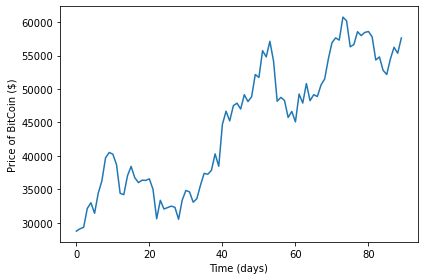

In [4]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Here's the autocorrelation function using the statistical definition, which unbiases, normalizes, and standardizes; that is, it shifts the mean to zero, divides through by standard deviation, and divides the sum by N.

In [5]:
def autocorr(wave):
    """Computes and plots the autocorrelation function.

    wave: Wave
    """
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [6]:
def serial_corr(wave, lag=1):
    """Computes serial correlation with given lag.

    wave: Wave
    lag: integer, how much to shift the wave

    returns: float correlation coefficient
    """
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

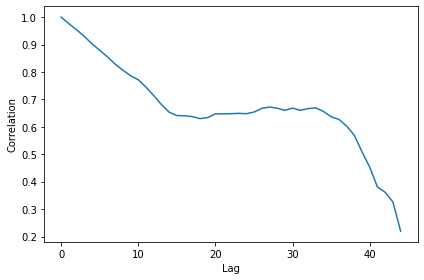

In [7]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

The ACF drops off slowly as lag increases, suggesting some kind of pink noise.

We can compare my implementation of `autocorr` with `np.correlate`, which uses the definition of correlation used in signal processing.  It doesn't unbias, normalize, or standardize the wave.

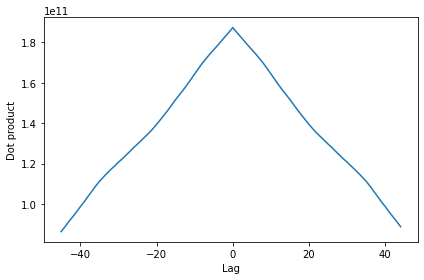

In [8]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate(xlabel='Lag',
         ylabel='Dot product')

The second half of the result corresponds to positive lags:

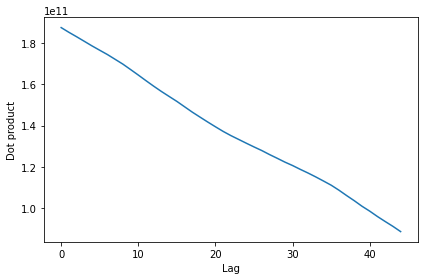

In [9]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

We can standardize the results after the fact by dividing through by `lengths`:

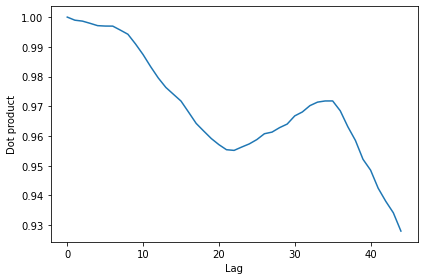

In [10]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Now we can compare the two.

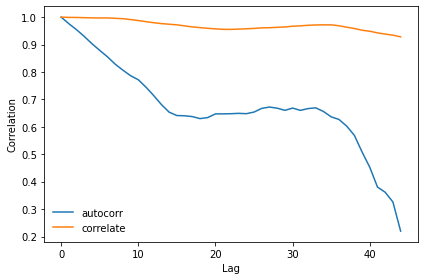

In [11]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

Even after standardizing, the results look substantially different. 

For this dataset, the statistical definition of ACF is probably more appropriate.

## Exercise 2

The example code in `chap05.ipynb` shows how to use autocorrelation
to estimate the fundamental frequency of a periodic signal.
Encapsulate this code in a function called `estimate_fundamental`,
and use it to track the pitch of a recorded sound.

To see how well it works, try superimposing your pitch estimates on a
spectrogram of the recording.

In [12]:
from thinkdsp import read_wave

wave = read_wave('Sounds/28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

I'll use the same example from `chap05.ipynb`.  Here's the spectrogram:

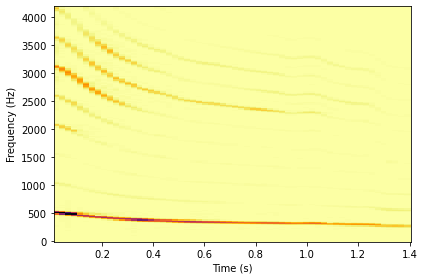

In [13]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)', 
         ylabel='Frequency (Hz)')

And here's a function that encapsulates the code from Chapter 5.  In general, finding the first, highest peak in the autocorrelation function is tricky.  I kept it simple by specifying the range of lags to search.

In [14]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Here's an example of how it works.

In [15]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

And here's a loop that tracks pitch over the sample.

The `ts` are the mid-points of each segment.

In [16]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Here's the pitch-tracking curve superimposed on the spectrogram:

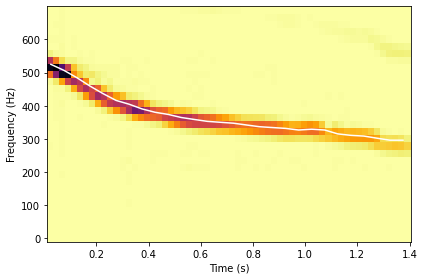

In [17]:
wave.make_spectrogram(2048).plot(high=700)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)', 
                     ylabel='Frequency (Hz)')

Looks pretty good!